## 1. Знакомстов с данными

In [4]:
# скачиваем, распаковываем
!gdown --fuzzy "https://drive.google.com/file/d/1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO/view?usp=sharing" -O handout.tar.gz
!tar -xzf handout.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO
From (redirected): https://drive.google.com/uc?id=1j3Pey7vhGA5_OYrjos-gDwv5_gm7BPBO&confirm=t&uuid=d596c364-54de-4174-b68b-3868042b8486
To: /content/handout.tar.gz
100% 884M/884M [00:09<00:00, 90.2MB/s]


In [5]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))


CPU times: user 213 ms, sys: 417 ms, total: 630 ms
Wall time: 642 ms


In [6]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


Картинки представлены эмбедингами длины 2048. К каждой картинке 5 описаний, подписи уже токенизированы и приведены к нижнему регистру.

In [7]:
#добавляем токены конца и начала
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i]
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]

In [8]:
captions[0][0]

['#START#',
 'people',
 'shopping',
 'in',
 'an',
 'open',
 'market',
 'for',
 'vegetables',
 '.',
 '#END#']

Подсчет частоты употребления слов

In [9]:
from collections import Counter
word_counts = Counter()
for img_caps in captions:
    for tokens in img_caps:
        word_counts.update(tokens)

In [10]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}
print("Размер словаря:", n_tokens)

Размер словаря: 10403


In [11]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))

    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [12]:
import pandas as pd
import random

idx = random.randint(0, len(captions)-1)

m = captions[idx]
df = pd.DataFrame(m)
df.index = [f"caption_{i}" for i in range(len(m))]
display(df)

print()

m = as_matrix(m)
df = pd.DataFrame(m)
df.index = [f"caption_{i}" for i in range(len(m))]
display(df)


0   1         2         3          4        5       6      7   \
caption_0  #START#   a     large  elephant    walking     down       a   road   
caption_1  #START#   a     large  elephant      moves       to   cross    the   
caption_2  #START#  an  elephant  standing       next       to     two  other   
caption_3  #START#  an    family        of  elephants  prepare      to  cross   
caption_4  #START#   a    family        of  elephants      are  trying     to   

                  8         9   ...        12     13    14       15        16  \
caption_0       past      wild  ...     #END#   None  None     None      None   
caption_1    highway     while  ...  elephant  waits  with  another  elephant   
caption_2  elephants  crossing  ...         .  #END#  None     None      None   
caption_3          a      road  ...      None   None  None     None      None   
caption_4      cross       the  ...     #END#   None  None     None      None   

             17    18     19    20     21  
caption_0  None  None   None  None   None  
caption_1    by   the  trees     .  #END#  
caption_2  None  None   None  None   None  
caption_3  None  None   None  None   None  
caption_4  None  None   None  None   None  

[5 rows x 22 columns]

0   1    2    3     4     5     6     7     8     9   ...   12  \
caption_0   1  24   21  458   412    31    24   103   228   518  ...    2   
caption_1   1  24   21  458  2458   117  1239    45  1577   174  ...  458   
caption_2   1   7  458   94   193   117    88   109   468  1237  ...   12   
caption_3   1   7  216   14   468  1585   117  1239    24   103  ...    3   
caption_4   1  24  216   14   468    17  1236   117  1239    45  ...    2   

             13  14  15   16   17  18   19  20  21  
caption_0     3   3   3    3    3   3    3   3   3  
caption_1  1028  58  59  458  163  45  194  12   2  
caption_2     2   3   3    3    3   3    3   3   3  
caption_3     3   3   3    3    3   3    3   3   3  
caption_4     3   3   3    3    3   3    3   3   3  

[5 rows x 22 columns]

## 2. Построение RNN-модели

In [13]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [14]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()

        # a layer that converts conv features to
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)

        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size, padding_idx=pad_ix)

        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM.
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=lstm_units, batch_first=True)

        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)

    def forward(self, image_vectors, captions_ix):
        """
        Apply the network in training mode.
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)

        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)

        # apply recurrent layer to captions_emb.
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, _ = self.lstm(captions_emb, (initial_hid.unsqueeze(0), initial_cell.unsqueeze(0)))

        # compute logits from lstm_out
        logits = self.logits(lstm_out)

        return logits

In [15]:
network = CaptionNet(n_tokens)

In [16]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

# проверяем что размеры правильные
print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [17]:
import torch.nn as nn

def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i].
        padded with pad_ix
    :returns: scalar crossentropy loss as tensor with shape [1]
    """
    # вход и цель
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    # логиты сети
    logits_for_next = network.forward(image_vectors, captions_ix_inp)

    # reshape для CrossEntropyLoss
    batch_size, seq_len, n_tokens = logits_for_next.shape
    logits_flat = logits_for_next.reshape(-1, n_tokens)
    targets_flat = captions_ix_next.reshape(-1)

    # loss с игнорированием паддинга
    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = criterion(logits_flat, targets_flat)

    return loss.unsqueeze(0)


In [18]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

In [19]:
import torch.optim as optim

# создаём оптимизатор Adam для всех параметров сети
optimizer = optim.Adam(network.parameters(), lr=1e-3)


## 3. Обучение

In [20]:
from sklearn.model_selection import train_test_split
# captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [21]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):

    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)

    #get images
    batch_images = img_codes[random_image_ix]

    #5-7 captions for each image
    captions_for_batch_images = [captions[i] for i in random_image_ix]

    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))

    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)

    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)

In [22]:
generate_batch(img_codes,captions,3)

(tensor([[0.1909, 0.1599, 0.5193,  ..., 0.0801, 0.2153, 0.6070],
         [0.3161, 0.1858, 0.2389,  ..., 0.6076, 0.5628, 0.6125],
         [0.2935, 0.3402, 0.5235,  ..., 0.0442, 0.7085, 0.0809]]),
 tensor([[   1, 3728, 1232,    6,   45,   95,   14,   24,  392,  150,   12,    2,
             3,    3],
         [   1,   24, 2140,   14,   24, 1308,  262,   58,   24,  195, 1015,   12,
             2,    3],
         [   1,   24,  262,    6,   24,    0, 1156,  624,  117, 2294,   24,  541,
           578,    2]]))

In [210]:
batch_size = 50  # adjust me
n_epochs = 180  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5

In [211]:
from tqdm import tqdm
import torch

# Определяем устройство: GPU если доступно, иначе CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = network.to(device)

# Настройка оптимизатора (если ещё не создан)
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# Гиперпараметры
grad_clip = 5.0  # максимальная норма градиентов

# Основной цикл обучения
for epoch in range(n_epochs):

    train_loss = 0
    network.train(True)  # включаем режим тренировки (dropout, batchnorm)

    for _ in tqdm(range(n_batches_per_epoch)):

        # Генерация батча
        batch_images, batch_captions_ix = generate_batch(train_img_codes, train_captions, batch_size)
        batch_images = batch_images.to(device)
        batch_captions_ix = batch_captions_ix.to(device)

        # Вычисление loss
        loss_t = compute_loss(network, batch_images, batch_captions_ix)

        # Обновление весов
        optimizer.zero_grad()
        loss_t.backward()
        torch.nn.utils.clip_grad_norm_(network.parameters(), grad_clip)
        optimizer.step()

        train_loss += loss_t.item()

    train_loss /= n_batches_per_epoch

    # Валидация
    val_loss = 0
    network.train(False)  # отключаем dropout, batchnorm
    for _ in range(n_validation_batches):
        with torch.no_grad():
            batch_images, batch_captions_ix = generate_batch(val_img_codes, val_captions, batch_size)
            batch_images = batch_images.to(device)
            batch_captions_ix = batch_captions_ix.to(device)
            loss_t = compute_loss(network, batch_images, batch_captions_ix)
            val_loss += loss_t.item()
    val_loss /= n_validation_batches

    print(f'\nEpoch: {epoch}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}')

print("Finished!")


100%|██████████| 50/50 [00:00<00:00, 81.95it/s]



Epoch: 0, train loss: 2.2488, val loss: 2.4034


100%|██████████| 50/50 [00:00<00:00, 100.03it/s]



Epoch: 1, train loss: 2.2452, val loss: 2.4661


100%|██████████| 50/50 [00:00<00:00, 92.35it/s]



Epoch: 2, train loss: 2.2839, val loss: 2.2667


100%|██████████| 50/50 [00:00<00:00, 98.13it/s]



Epoch: 3, train loss: 2.2776, val loss: 2.4002


100%|██████████| 50/50 [00:00<00:00, 96.69it/s]



Epoch: 4, train loss: 2.2637, val loss: 2.6243


100%|██████████| 50/50 [00:00<00:00, 96.17it/s]



Epoch: 5, train loss: 2.2501, val loss: 2.5946


100%|██████████| 50/50 [00:00<00:00, 97.46it/s]



Epoch: 6, train loss: 2.2688, val loss: 2.4416


100%|██████████| 50/50 [00:00<00:00, 98.43it/s]



Epoch: 7, train loss: 2.2835, val loss: 2.4096


100%|██████████| 50/50 [00:00<00:00, 102.28it/s]



Epoch: 8, train loss: 2.2889, val loss: 2.5457


100%|██████████| 50/50 [00:00<00:00, 99.86it/s]



Epoch: 9, train loss: 2.2878, val loss: 2.4020


100%|██████████| 50/50 [00:00<00:00, 94.90it/s]



Epoch: 10, train loss: 2.2837, val loss: 2.5589


100%|██████████| 50/50 [00:00<00:00, 94.94it/s]



Epoch: 11, train loss: 2.2702, val loss: 2.5246


100%|██████████| 50/50 [00:00<00:00, 97.50it/s]



Epoch: 12, train loss: 2.2691, val loss: 2.5175


100%|██████████| 50/50 [00:00<00:00, 96.18it/s]



Epoch: 13, train loss: 2.3008, val loss: 2.4036


100%|██████████| 50/50 [00:00<00:00, 96.30it/s]



Epoch: 14, train loss: 2.3059, val loss: 2.5670


100%|██████████| 50/50 [00:00<00:00, 96.63it/s]



Epoch: 15, train loss: 2.2883, val loss: 2.4039


100%|██████████| 50/50 [00:00<00:00, 96.63it/s]



Epoch: 16, train loss: 2.3066, val loss: 2.4601


100%|██████████| 50/50 [00:00<00:00, 97.60it/s]



Epoch: 17, train loss: 2.2862, val loss: 2.3295


100%|██████████| 50/50 [00:00<00:00, 95.75it/s]



Epoch: 18, train loss: 2.2463, val loss: 2.5260


100%|██████████| 50/50 [00:00<00:00, 95.10it/s]



Epoch: 19, train loss: 2.2834, val loss: 2.4786


100%|██████████| 50/50 [00:00<00:00, 90.64it/s]



Epoch: 20, train loss: 2.2879, val loss: 2.4104


100%|██████████| 50/50 [00:00<00:00, 89.52it/s]



Epoch: 21, train loss: 2.2639, val loss: 2.4028


100%|██████████| 50/50 [00:00<00:00, 89.75it/s]



Epoch: 22, train loss: 2.2873, val loss: 2.4494


100%|██████████| 50/50 [00:00<00:00, 86.68it/s]



Epoch: 23, train loss: 2.2636, val loss: 2.4372


100%|██████████| 50/50 [00:00<00:00, 91.26it/s]



Epoch: 24, train loss: 2.2910, val loss: 2.4972


100%|██████████| 50/50 [00:00<00:00, 95.61it/s]



Epoch: 25, train loss: 2.2773, val loss: 2.3816


100%|██████████| 50/50 [00:00<00:00, 99.50it/s]



Epoch: 26, train loss: 2.2808, val loss: 2.4640


100%|██████████| 50/50 [00:00<00:00, 97.35it/s]



Epoch: 27, train loss: 2.2695, val loss: 2.4573


100%|██████████| 50/50 [00:00<00:00, 94.87it/s]



Epoch: 28, train loss: 2.2806, val loss: 2.5184


100%|██████████| 50/50 [00:00<00:00, 93.96it/s]



Epoch: 29, train loss: 2.2390, val loss: 2.3946


100%|██████████| 50/50 [00:00<00:00, 97.44it/s]



Epoch: 30, train loss: 2.2860, val loss: 2.4147


100%|██████████| 50/50 [00:00<00:00, 99.00it/s]



Epoch: 31, train loss: 2.2582, val loss: 2.4351


100%|██████████| 50/50 [00:00<00:00, 94.85it/s]



Epoch: 32, train loss: 2.2429, val loss: 2.5113


100%|██████████| 50/50 [00:00<00:00, 90.65it/s]



Epoch: 33, train loss: 2.2569, val loss: 2.4370


100%|██████████| 50/50 [00:00<00:00, 95.94it/s]



Epoch: 34, train loss: 2.2725, val loss: 2.5665


100%|██████████| 50/50 [00:00<00:00, 94.37it/s]



Epoch: 35, train loss: 2.2728, val loss: 2.4331


100%|██████████| 50/50 [00:00<00:00, 91.57it/s]



Epoch: 36, train loss: 2.2811, val loss: 2.4613


100%|██████████| 50/50 [00:00<00:00, 95.47it/s]



Epoch: 37, train loss: 2.2898, val loss: 2.4256


100%|██████████| 50/50 [00:00<00:00, 95.17it/s]



Epoch: 38, train loss: 2.2272, val loss: 2.5272


100%|██████████| 50/50 [00:00<00:00, 93.53it/s]



Epoch: 39, train loss: 2.2715, val loss: 2.4607


100%|██████████| 50/50 [00:00<00:00, 98.09it/s]



Epoch: 40, train loss: 2.2651, val loss: 2.4035


100%|██████████| 50/50 [00:00<00:00, 95.96it/s]



Epoch: 41, train loss: 2.2888, val loss: 2.4463


100%|██████████| 50/50 [00:00<00:00, 88.90it/s]



Epoch: 42, train loss: 2.2736, val loss: 2.4180


100%|██████████| 50/50 [00:00<00:00, 92.31it/s]



Epoch: 43, train loss: 2.2719, val loss: 2.3871


100%|██████████| 50/50 [00:00<00:00, 91.68it/s]



Epoch: 44, train loss: 2.2565, val loss: 2.3942


100%|██████████| 50/50 [00:00<00:00, 91.36it/s]



Epoch: 45, train loss: 2.2554, val loss: 2.4041


100%|██████████| 50/50 [00:00<00:00, 85.25it/s]



Epoch: 46, train loss: 2.2806, val loss: 2.3265


100%|██████████| 50/50 [00:00<00:00, 86.69it/s]



Epoch: 47, train loss: 2.2937, val loss: 2.4972


100%|██████████| 50/50 [00:00<00:00, 91.92it/s]



Epoch: 48, train loss: 2.2578, val loss: 2.5403


100%|██████████| 50/50 [00:00<00:00, 94.81it/s]



Epoch: 49, train loss: 2.2243, val loss: 2.3990


100%|██████████| 50/50 [00:00<00:00, 94.45it/s]



Epoch: 50, train loss: 2.2753, val loss: 2.5991


100%|██████████| 50/50 [00:00<00:00, 96.75it/s]



Epoch: 51, train loss: 2.2573, val loss: 2.4371


100%|██████████| 50/50 [00:00<00:00, 95.93it/s]



Epoch: 52, train loss: 2.2245, val loss: 2.4781


100%|██████████| 50/50 [00:00<00:00, 93.37it/s]



Epoch: 53, train loss: 2.2395, val loss: 2.5271


100%|██████████| 50/50 [00:00<00:00, 93.21it/s]



Epoch: 54, train loss: 2.2483, val loss: 2.4489


100%|██████████| 50/50 [00:00<00:00, 95.71it/s]



Epoch: 55, train loss: 2.2550, val loss: 2.4857


100%|██████████| 50/50 [00:00<00:00, 95.91it/s]



Epoch: 56, train loss: 2.2424, val loss: 2.2877


100%|██████████| 50/50 [00:00<00:00, 93.08it/s]



Epoch: 57, train loss: 2.2660, val loss: 2.4223


100%|██████████| 50/50 [00:00<00:00, 91.88it/s]



Epoch: 58, train loss: 2.2626, val loss: 2.3061


100%|██████████| 50/50 [00:00<00:00, 95.59it/s]



Epoch: 59, train loss: 2.2534, val loss: 2.3747


100%|██████████| 50/50 [00:00<00:00, 95.26it/s]



Epoch: 60, train loss: 2.2281, val loss: 2.3154


100%|██████████| 50/50 [00:00<00:00, 94.08it/s]



Epoch: 61, train loss: 2.2419, val loss: 2.4166


100%|██████████| 50/50 [00:00<00:00, 94.35it/s]



Epoch: 62, train loss: 2.2667, val loss: 2.5253


100%|██████████| 50/50 [00:00<00:00, 90.98it/s]



Epoch: 63, train loss: 2.2693, val loss: 2.4126


100%|██████████| 50/50 [00:00<00:00, 90.86it/s]



Epoch: 64, train loss: 2.2765, val loss: 2.4027


100%|██████████| 50/50 [00:00<00:00, 93.53it/s]



Epoch: 65, train loss: 2.2364, val loss: 2.3912


100%|██████████| 50/50 [00:00<00:00, 92.19it/s]



Epoch: 66, train loss: 2.2901, val loss: 2.4220


100%|██████████| 50/50 [00:00<00:00, 88.05it/s]



Epoch: 67, train loss: 2.2918, val loss: 2.4146


100%|██████████| 50/50 [00:00<00:00, 89.76it/s]



Epoch: 68, train loss: 2.2511, val loss: 2.4482


100%|██████████| 50/50 [00:01<00:00, 40.20it/s]



Epoch: 69, train loss: 2.2821, val loss: 2.3734


100%|██████████| 50/50 [00:00<00:00, 84.38it/s]



Epoch: 70, train loss: 2.2368, val loss: 2.4218


100%|██████████| 50/50 [00:00<00:00, 76.02it/s]



Epoch: 71, train loss: 2.2263, val loss: 2.3201


100%|██████████| 50/50 [00:00<00:00, 88.59it/s]



Epoch: 72, train loss: 2.2655, val loss: 2.5376


100%|██████████| 50/50 [00:00<00:00, 95.01it/s]



Epoch: 73, train loss: 2.2639, val loss: 2.2993


100%|██████████| 50/50 [00:00<00:00, 89.47it/s]



Epoch: 74, train loss: 2.2662, val loss: 2.3960


100%|██████████| 50/50 [00:00<00:00, 93.69it/s]



Epoch: 75, train loss: 2.2467, val loss: 2.4011


100%|██████████| 50/50 [00:00<00:00, 96.34it/s]



Epoch: 76, train loss: 2.2596, val loss: 2.5965


100%|██████████| 50/50 [00:00<00:00, 92.41it/s]



Epoch: 77, train loss: 2.2616, val loss: 2.4446


100%|██████████| 50/50 [00:00<00:00, 91.03it/s]



Epoch: 78, train loss: 2.2544, val loss: 2.4998


100%|██████████| 50/50 [00:00<00:00, 93.00it/s]



Epoch: 79, train loss: 2.2482, val loss: 2.5837


100%|██████████| 50/50 [00:00<00:00, 89.31it/s]



Epoch: 80, train loss: 2.2705, val loss: 2.3533


100%|██████████| 50/50 [00:00<00:00, 94.97it/s]



Epoch: 81, train loss: 2.2422, val loss: 2.4533


100%|██████████| 50/50 [00:00<00:00, 93.37it/s]



Epoch: 82, train loss: 2.2468, val loss: 2.5227


100%|██████████| 50/50 [00:00<00:00, 93.40it/s]



Epoch: 83, train loss: 2.2484, val loss: 2.3254


100%|██████████| 50/50 [00:00<00:00, 95.30it/s]



Epoch: 84, train loss: 2.2012, val loss: 2.2754


100%|██████████| 50/50 [00:00<00:00, 96.00it/s]



Epoch: 85, train loss: 2.2443, val loss: 2.4561


100%|██████████| 50/50 [00:00<00:00, 89.80it/s]



Epoch: 86, train loss: 2.2835, val loss: 2.4219


100%|██████████| 50/50 [00:00<00:00, 93.73it/s]



Epoch: 87, train loss: 2.2877, val loss: 2.4574


100%|██████████| 50/50 [00:00<00:00, 92.32it/s]



Epoch: 88, train loss: 2.2665, val loss: 2.3754


100%|██████████| 50/50 [00:00<00:00, 92.34it/s]



Epoch: 89, train loss: 2.2443, val loss: 2.4299


100%|██████████| 50/50 [00:00<00:00, 91.84it/s]



Epoch: 90, train loss: 2.2336, val loss: 2.4884


100%|██████████| 50/50 [00:00<00:00, 85.93it/s]



Epoch: 91, train loss: 2.2808, val loss: 2.3828


100%|██████████| 50/50 [00:00<00:00, 88.35it/s]



Epoch: 92, train loss: 2.2326, val loss: 2.4065


100%|██████████| 50/50 [00:00<00:00, 90.72it/s]



Epoch: 93, train loss: 2.2323, val loss: 2.5911


100%|██████████| 50/50 [00:00<00:00, 88.58it/s]



Epoch: 94, train loss: 2.2180, val loss: 2.4028


100%|██████████| 50/50 [00:00<00:00, 89.09it/s]



Epoch: 95, train loss: 2.2481, val loss: 2.4246


100%|██████████| 50/50 [00:00<00:00, 93.02it/s]



Epoch: 96, train loss: 2.2460, val loss: 2.4304


100%|██████████| 50/50 [00:00<00:00, 94.33it/s]



Epoch: 97, train loss: 2.1977, val loss: 2.4452


100%|██████████| 50/50 [00:00<00:00, 91.46it/s]



Epoch: 98, train loss: 2.2529, val loss: 2.3893


100%|██████████| 50/50 [00:00<00:00, 95.99it/s]



Epoch: 99, train loss: 2.2152, val loss: 2.4336


100%|██████████| 50/50 [00:00<00:00, 94.04it/s]



Epoch: 100, train loss: 2.2643, val loss: 2.4564


100%|██████████| 50/50 [00:00<00:00, 94.06it/s]



Epoch: 101, train loss: 2.2244, val loss: 2.4076


100%|██████████| 50/50 [00:00<00:00, 92.77it/s]



Epoch: 102, train loss: 2.2835, val loss: 2.3627


100%|██████████| 50/50 [00:00<00:00, 96.65it/s]



Epoch: 103, train loss: 2.2311, val loss: 2.4517


100%|██████████| 50/50 [00:00<00:00, 93.56it/s]



Epoch: 104, train loss: 2.2435, val loss: 2.3909


100%|██████████| 50/50 [00:00<00:00, 88.13it/s]



Epoch: 105, train loss: 2.2773, val loss: 2.4921


100%|██████████| 50/50 [00:00<00:00, 96.40it/s]



Epoch: 106, train loss: 2.2327, val loss: 2.3919


100%|██████████| 50/50 [00:00<00:00, 93.83it/s]



Epoch: 107, train loss: 2.2577, val loss: 2.4236


100%|██████████| 50/50 [00:00<00:00, 93.96it/s]



Epoch: 108, train loss: 2.2120, val loss: 2.4485


100%|██████████| 50/50 [00:00<00:00, 93.95it/s]



Epoch: 109, train loss: 2.2806, val loss: 2.5421


100%|██████████| 50/50 [00:00<00:00, 94.48it/s]



Epoch: 110, train loss: 2.2498, val loss: 2.5127


100%|██████████| 50/50 [00:00<00:00, 93.28it/s]



Epoch: 111, train loss: 2.2518, val loss: 2.4033


100%|██████████| 50/50 [00:00<00:00, 91.65it/s]



Epoch: 112, train loss: 2.2373, val loss: 2.3766


100%|██████████| 50/50 [00:00<00:00, 93.64it/s]



Epoch: 113, train loss: 2.2217, val loss: 2.4935


100%|██████████| 50/50 [00:00<00:00, 79.68it/s]



Epoch: 114, train loss: 2.2355, val loss: 2.3179


100%|██████████| 50/50 [00:00<00:00, 89.16it/s]



Epoch: 115, train loss: 2.2770, val loss: 2.4998


100%|██████████| 50/50 [00:00<00:00, 95.69it/s]



Epoch: 116, train loss: 2.2497, val loss: 2.5137


100%|██████████| 50/50 [00:00<00:00, 90.81it/s]



Epoch: 117, train loss: 2.2564, val loss: 2.4725


100%|██████████| 50/50 [00:00<00:00, 92.82it/s]



Epoch: 118, train loss: 2.2340, val loss: 2.4378


100%|██████████| 50/50 [00:00<00:00, 90.75it/s]



Epoch: 119, train loss: 2.2671, val loss: 2.4670


100%|██████████| 50/50 [00:00<00:00, 95.30it/s]



Epoch: 120, train loss: 2.2320, val loss: 2.5257


100%|██████████| 50/50 [00:00<00:00, 95.22it/s]



Epoch: 121, train loss: 2.2315, val loss: 2.4503


100%|██████████| 50/50 [00:00<00:00, 90.17it/s]



Epoch: 122, train loss: 2.2378, val loss: 2.3452


100%|██████████| 50/50 [00:00<00:00, 94.17it/s]



Epoch: 123, train loss: 2.2254, val loss: 2.3036


100%|██████████| 50/50 [00:00<00:00, 94.04it/s]



Epoch: 124, train loss: 2.2211, val loss: 2.4626


100%|██████████| 50/50 [00:00<00:00, 96.26it/s]



Epoch: 125, train loss: 2.1972, val loss: 2.3631


100%|██████████| 50/50 [00:00<00:00, 94.34it/s]



Epoch: 126, train loss: 2.2171, val loss: 2.5095


100%|██████████| 50/50 [00:00<00:00, 98.11it/s]



Epoch: 127, train loss: 2.2438, val loss: 2.3837


100%|██████████| 50/50 [00:00<00:00, 93.05it/s]



Epoch: 128, train loss: 2.2324, val loss: 2.4738


100%|██████████| 50/50 [00:00<00:00, 92.95it/s]



Epoch: 129, train loss: 2.2323, val loss: 2.4477


100%|██████████| 50/50 [00:00<00:00, 94.63it/s]



Epoch: 130, train loss: 2.2395, val loss: 2.3362


100%|██████████| 50/50 [00:00<00:00, 94.14it/s]



Epoch: 131, train loss: 2.2285, val loss: 2.5098


100%|██████████| 50/50 [00:00<00:00, 90.08it/s]



Epoch: 132, train loss: 2.2184, val loss: 2.4243


100%|██████████| 50/50 [00:00<00:00, 90.61it/s]



Epoch: 133, train loss: 2.1986, val loss: 2.3871


100%|██████████| 50/50 [00:00<00:00, 89.37it/s]



Epoch: 134, train loss: 2.2279, val loss: 2.4187


100%|██████████| 50/50 [00:00<00:00, 90.17it/s]



Epoch: 135, train loss: 2.2485, val loss: 2.4332


100%|██████████| 50/50 [00:00<00:00, 91.05it/s]



Epoch: 136, train loss: 2.2045, val loss: 2.4357


100%|██████████| 50/50 [00:00<00:00, 85.20it/s]



Epoch: 137, train loss: 2.2161, val loss: 2.3342


100%|██████████| 50/50 [00:00<00:00, 90.03it/s]



Epoch: 138, train loss: 2.2381, val loss: 2.5976


100%|██████████| 50/50 [00:00<00:00, 92.05it/s]



Epoch: 139, train loss: 2.2534, val loss: 2.4551


100%|██████████| 50/50 [00:00<00:00, 96.94it/s]



Epoch: 140, train loss: 2.1992, val loss: 2.4853


100%|██████████| 50/50 [00:00<00:00, 96.81it/s]



Epoch: 141, train loss: 2.2427, val loss: 2.4320


100%|██████████| 50/50 [00:00<00:00, 92.38it/s]



Epoch: 142, train loss: 2.2272, val loss: 2.3772


100%|██████████| 50/50 [00:00<00:00, 95.64it/s]



Epoch: 143, train loss: 2.2347, val loss: 2.5139


100%|██████████| 50/50 [00:00<00:00, 97.55it/s]



Epoch: 144, train loss: 2.2111, val loss: 2.4362


100%|██████████| 50/50 [00:00<00:00, 96.25it/s]



Epoch: 145, train loss: 2.2384, val loss: 2.3689


100%|██████████| 50/50 [00:00<00:00, 93.82it/s]



Epoch: 146, train loss: 2.2118, val loss: 2.5119


100%|██████████| 50/50 [00:00<00:00, 95.26it/s]



Epoch: 147, train loss: 2.2129, val loss: 2.4193


100%|██████████| 50/50 [00:00<00:00, 91.47it/s]



Epoch: 148, train loss: 2.1885, val loss: 2.5020


100%|██████████| 50/50 [00:00<00:00, 94.01it/s]



Epoch: 149, train loss: 2.2447, val loss: 2.4560


100%|██████████| 50/50 [00:00<00:00, 94.98it/s]



Epoch: 150, train loss: 2.2303, val loss: 2.3788


100%|██████████| 50/50 [00:00<00:00, 98.83it/s]



Epoch: 151, train loss: 2.2135, val loss: 2.5340


100%|██████████| 50/50 [00:00<00:00, 94.13it/s]



Epoch: 152, train loss: 2.2592, val loss: 2.5004


100%|██████████| 50/50 [00:00<00:00, 95.60it/s]



Epoch: 153, train loss: 2.2325, val loss: 2.5890


100%|██████████| 50/50 [00:00<00:00, 92.43it/s]



Epoch: 154, train loss: 2.2321, val loss: 2.4151


100%|██████████| 50/50 [00:00<00:00, 95.46it/s]



Epoch: 155, train loss: 2.2166, val loss: 2.3955


100%|██████████| 50/50 [00:00<00:00, 94.93it/s]



Epoch: 156, train loss: 2.2117, val loss: 2.5212


100%|██████████| 50/50 [00:00<00:00, 94.96it/s]



Epoch: 157, train loss: 2.2185, val loss: 2.5700


100%|██████████| 50/50 [00:00<00:00, 95.04it/s]



Epoch: 158, train loss: 2.2126, val loss: 2.3553


100%|██████████| 50/50 [00:00<00:00, 93.31it/s]



Epoch: 159, train loss: 2.2213, val loss: 2.3807


100%|██████████| 50/50 [00:00<00:00, 87.91it/s]



Epoch: 160, train loss: 2.2198, val loss: 2.6081


100%|██████████| 50/50 [00:00<00:00, 84.58it/s]



Epoch: 161, train loss: 2.2174, val loss: 2.4412


100%|██████████| 50/50 [00:00<00:00, 94.33it/s]



Epoch: 162, train loss: 2.1987, val loss: 2.4045


100%|██████████| 50/50 [00:00<00:00, 92.62it/s]



Epoch: 163, train loss: 2.2592, val loss: 2.4674


100%|██████████| 50/50 [00:00<00:00, 94.19it/s]



Epoch: 164, train loss: 2.2159, val loss: 2.4527


100%|██████████| 50/50 [00:00<00:00, 99.51it/s] 



Epoch: 165, train loss: 2.2360, val loss: 2.5318


100%|██████████| 50/50 [00:00<00:00, 94.23it/s]



Epoch: 166, train loss: 2.2631, val loss: 2.4610


100%|██████████| 50/50 [00:00<00:00, 94.57it/s]



Epoch: 167, train loss: 2.2279, val loss: 2.2931


100%|██████████| 50/50 [00:00<00:00, 92.44it/s]



Epoch: 168, train loss: 2.2475, val loss: 2.3062


100%|██████████| 50/50 [00:00<00:00, 92.94it/s]



Epoch: 169, train loss: 2.2232, val loss: 2.4523


100%|██████████| 50/50 [00:00<00:00, 94.08it/s]



Epoch: 170, train loss: 2.2267, val loss: 2.5333


100%|██████████| 50/50 [00:00<00:00, 98.77it/s]



Epoch: 171, train loss: 2.2163, val loss: 2.3426


100%|██████████| 50/50 [00:00<00:00, 94.86it/s]



Epoch: 172, train loss: 2.2025, val loss: 2.4002


100%|██████████| 50/50 [00:00<00:00, 95.70it/s]



Epoch: 173, train loss: 2.2082, val loss: 2.4218


100%|██████████| 50/50 [00:00<00:00, 91.89it/s]



Epoch: 174, train loss: 2.2375, val loss: 2.5384


100%|██████████| 50/50 [00:00<00:00, 94.76it/s]



Epoch: 175, train loss: 2.1901, val loss: 2.3310


100%|██████████| 50/50 [00:00<00:00, 89.27it/s]



Epoch: 176, train loss: 2.1995, val loss: 2.4606


100%|██████████| 50/50 [00:00<00:00, 91.71it/s]



Epoch: 177, train loss: 2.2111, val loss: 2.4260


100%|██████████| 50/50 [00:00<00:00, 96.68it/s]



Epoch: 178, train loss: 2.1913, val loss: 2.4112


100%|██████████| 50/50 [00:00<00:00, 95.12it/s]


Epoch: 179, train loss: 2.2245, val loss: 2.3784
Finished!


## 4. Применение обученной модели

In [212]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

In [213]:
network = network.to(device)
network.eval()  # отключаем dropout/batchnorm
inception = inception.to(device)
inception.eval()

BeheadedInception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 

In [214]:
import torch
import torch.nn.functional as F
import numpy as np

def generate_caption(image, caption_prefix=("#START#",),
                     t=1.0, sample=True, max_len=100):
    with torch.no_grad():
        image_tensor = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32).to(device)
        vectors_8x8, vectors_neck, logits = inception(image_tensor[None])
        vectors_neck = vectors_neck.to(device)

        caption_prefix = list(caption_prefix)

        for _ in range(max_len):
            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64).to(device)

            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().numpy()
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t)

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)
            if next_word == "#END#":
                break

    return caption_prefix



Пара примеров картинок
1) человек на скейтборде

In [349]:
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg


--2025-10-30 14:25:02--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2025-10-30 14:25:03--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 199.232.193.246, 199.232.197.246
Connecting to pyxis.nymag.com (pyxis.nymag.com)|199.232.193.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53.45K  --.-KB/s    in 0.007s  

2025-10-30 14:25:03 (7.64 MB/s) - ‘data/img.jpg’ saved [54731/547

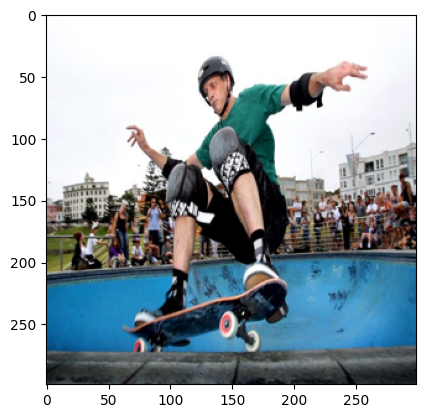

In [350]:
from PIL import Image
import numpy as np

img_path = 'data/img.jpg'
img = Image.open(img_path).convert('RGB')
img = img.resize((299, 299))  # размер для InceptionV3
img = np.array(img).astype('float32') / 255.0  # нормализация [0,1]
plt.imshow(img)

In [351]:
for i in range(10):
    caption_tokens = generate_caption(img, t=5.0, sample=True)
    caption_text = ' '.join(caption_tokens[1:-1])  # убираем #START# и #END#
    print(f"{i+1}: {caption_text}")

1: a man riding a skateboard up the side of a ramp .
2: a man riding a skateboard up the side of a ramp .
3: a man riding a skateboard up the side of a ramp .
4: a man riding a skateboard up the side of a ramp .
5: a man riding a skateboard up the side of a ramp .
6: a man riding a skateboard up the side of a ramp .
7: a man riding a skateboard up the side of a ramp .
8: a man riding a skateboard up the side of a ramp .
9: a man riding a skateboard up the side of a ramp .
10: a man riding a skateboard up the side of a ramp .


2) кот и пес сидят на диване

In [353]:
!wget https://i.pinimg.com/1200x/2f/95/5c/2f955c9d41e7488c01440073ae88d965.jpg -O data/img.jpg

--2025-10-30 14:25:31--  https://i.pinimg.com/1200x/2f/95/5c/2f955c9d41e7488c01440073ae88d965.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.56.109.78, 23.56.109.81, 2600:1406:5e00:6::17ce:bc38, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.56.109.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165508 (162K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 161.63K  --.-KB/s    in 0.01s   

2025-10-30 14:25:31 (13.0 MB/s) - ‘data/img.jpg’ saved [165508/165508]



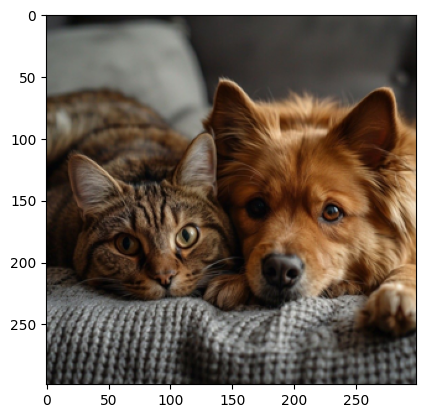

In [354]:
img_path = 'data/img.jpg'
img = Image.open(img_path).convert('RGB')
img = img.resize((299, 299))  # размер для InceptionV3
img = np.array(img).astype('float32') / 255.0  # нормализация [0,1]
plt.imshow(img)

In [356]:
for i in range(10):
    caption_tokens = generate_caption(img, t=5.0, sample=True)
    caption_text = ' '.join(caption_tokens[1:-1])  # убираем #START# и #END#
    print(f"{i+1}: {caption_text}")

1: a dog laying on a bed with a cat on the bed .
2: a cat is laying on a couch with a remote control .
3: a cat is sitting on a couch with a dog laying on its back
4: a dog laying on the bed with a cat on the bed .
5: a cat laying on a couch with a cat on it
6: a dog laying on a couch with a cat .
7: a cat sitting on a couch with a cat on the back
8: a dog laying on a couch with a cat on it .
9: a dog laying on a couch with a cat on it .
10: a dog laying on a bed with a red blanket .


3) Умный человек в очках скачать обои

In [357]:
!wget https://upload.wikimedia.org/wikipedia/ru/3/31/%D0%A3%D0%BC%D0%BD%D1%8B%D0%B9_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA_%D0%B2_%D0%BE%D1%87%D0%BA%D0%B0%D1%85_%D1%81%D0%BA%D0%B0%D1%87%D0%B0%D1%82%D1%8C_%D0%BE%D0%B1%D0%BE%D0%B8.jpeg -O data/img.jpg

--2025-10-30 14:26:54--  https://upload.wikimedia.org/wikipedia/ru/3/31/%D0%A3%D0%BC%D0%BD%D1%8B%D0%B9_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA_%D0%B2_%D0%BE%D1%87%D0%BA%D0%B0%D1%85_%D1%81%D0%BA%D0%B0%D1%87%D0%B0%D1%82%D1%8C_%D0%BE%D0%B1%D0%BE%D0%B8.jpeg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160442 (157K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 156.68K  --.-KB/s    in 0.05s   

2025-10-30 14:26:54 (2.90 MB/s) - ‘data/img.jpg’ saved [160442/160442]



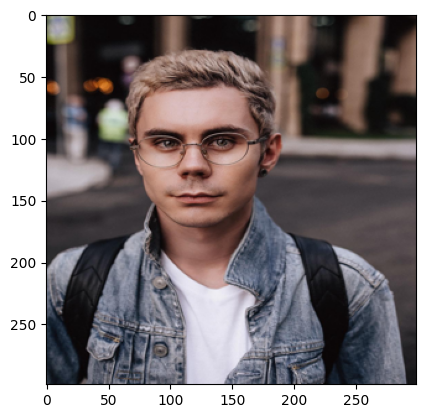

In [364]:
img_path = 'data/img.jpg'
img = Image.open(img_path).convert('RGB')
img = img.resize((299, 299))  # размер для InceptionV3
img = np.array(img).astype('float32') / 255.0  # нормализация [0,1]
plt.imshow(img)

In [365]:
for i in range(10):
    caption_tokens = generate_caption(img, t=5.0, sample=True)
    caption_text = ' '.join(caption_tokens[1:-1])  # убираем #START# и #END#
    print(f"{i+1}: {caption_text}")

1: a man wearing a tie and a hat
2: a man wearing a blue shirt and a tie .
3: a man wearing a blue shirt and a tie .
4: a man wearing a blue shirt and a tie .
5: a man wearing a blue shirt and a red tie .
6: a man wearing a tie and a hat .
7: a man with a beard and a blue tie .
8: a man wearing a hat and glasses .
9: a man wearing a hat and a tie .
10: a man wearing a blue shirt and a tie


## 4. Demo
тестируем на картинках

In [366]:
# папка с картинками
img_folder = "images"
img_files = [f for f in os.listdir(img_folder) if f.lower().endswith(".jpg")]
img_files.sort()
batch_size = 4
current_batch = 0

In [367]:

def show_next_batch():
    global current_batch
    start = current_batch * batch_size
    end = start + batch_size
    batch_files = img_files[start:end]
    if not batch_files:
        print("Больше картинок нет")
        return

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    for j, fname in enumerate(batch_files):
        img_path = os.path.join(img_folder, fname)
        img = Image.open(img_path).convert('RGB')
        img_resized = np.array(img.resize((299,299))).astype('float32') / 255.
        axes[j].imshow(img_resized)
        axes[j].axis('off')

        all_captions = []
        for _ in range(captions_per_image):
            caption_tokens = generate_caption(img_resized, t=5.0, sample=True)
            caption_text = ' '.join(caption_tokens[1:-1])
            all_captions.append(caption_text)
        axes[j].set_title('\n'.join(all_captions), fontsize=9)

    for k in range(len(batch_files), batch_size):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()

    current_batch += 1


1) хорошо угадываются распространенные сюжеты фото, вроде человека на велосипеде или за компьютером

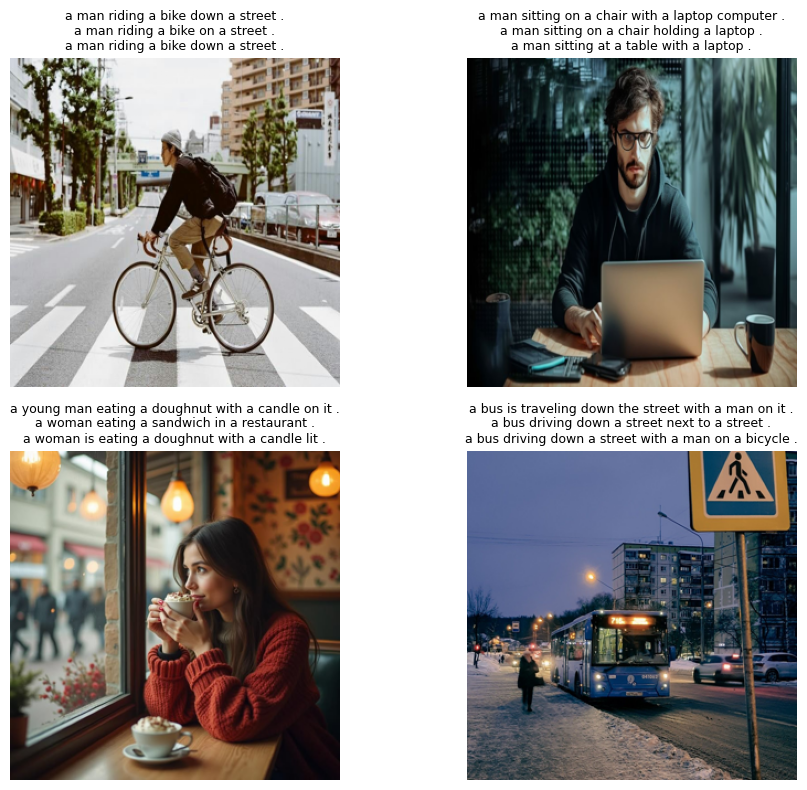

In [368]:
show_next_batch()

2) хорошо угадываются кошки и собаки, более специфических животных моделька уже не узнает

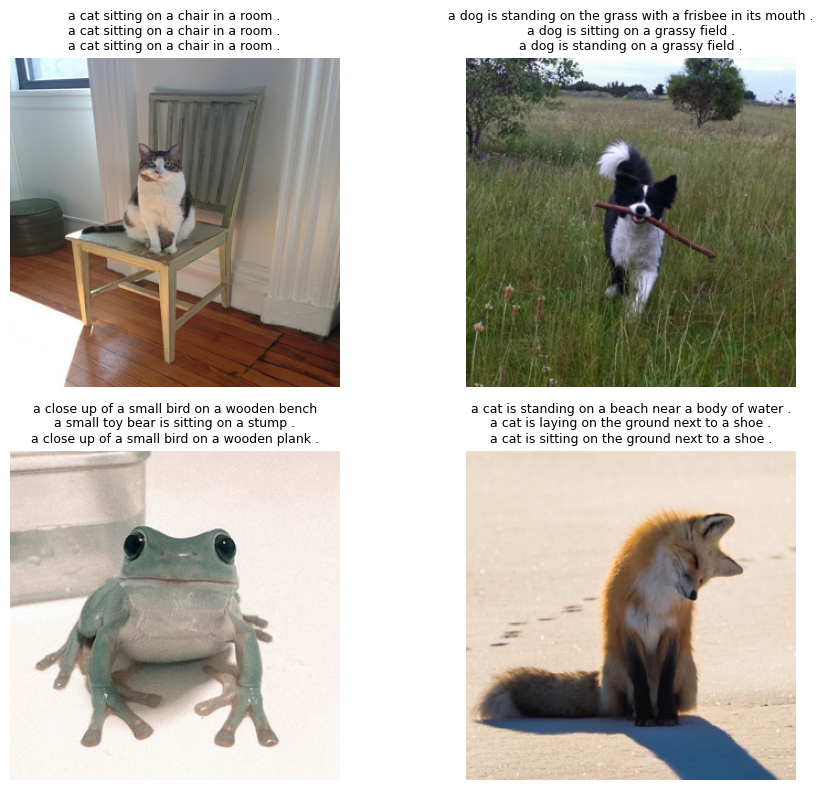

In [345]:
show_next_batch()

3) Аугментации: изменение цветов и размеров +- невилируются, перевод в чб ухудшает предсказание (что логично, потому что уменьшается само пространство признаком)

*P.s. Сразу видно датасет американский, моделька думает что палка это фрисби*

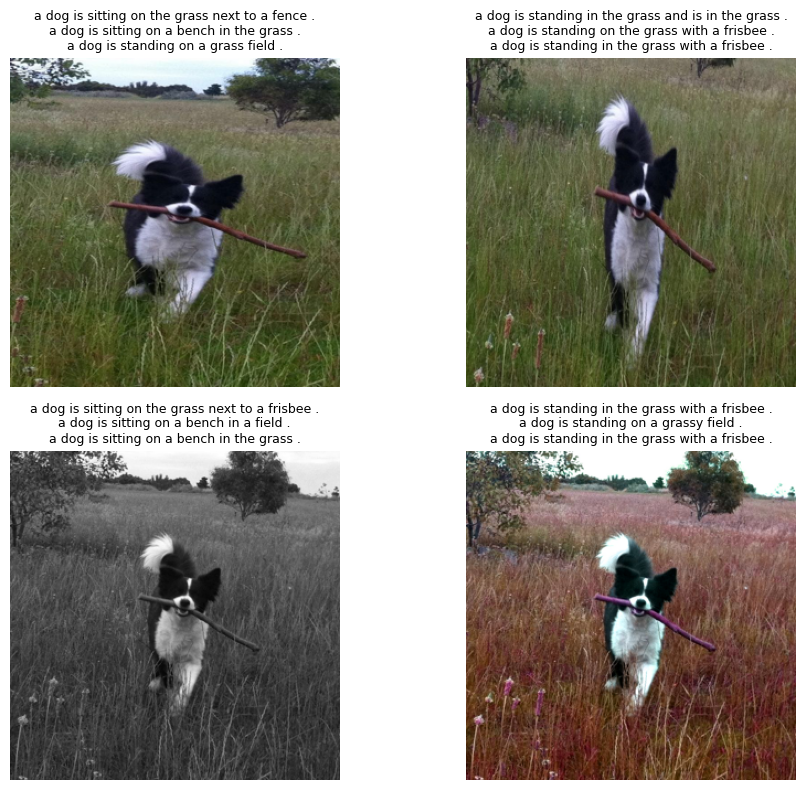

In [346]:
show_next_batch()

4) Вообще не угадывает пейзажные фото, ищет везде действующих персонажей: людей, животных, хотя бы машины

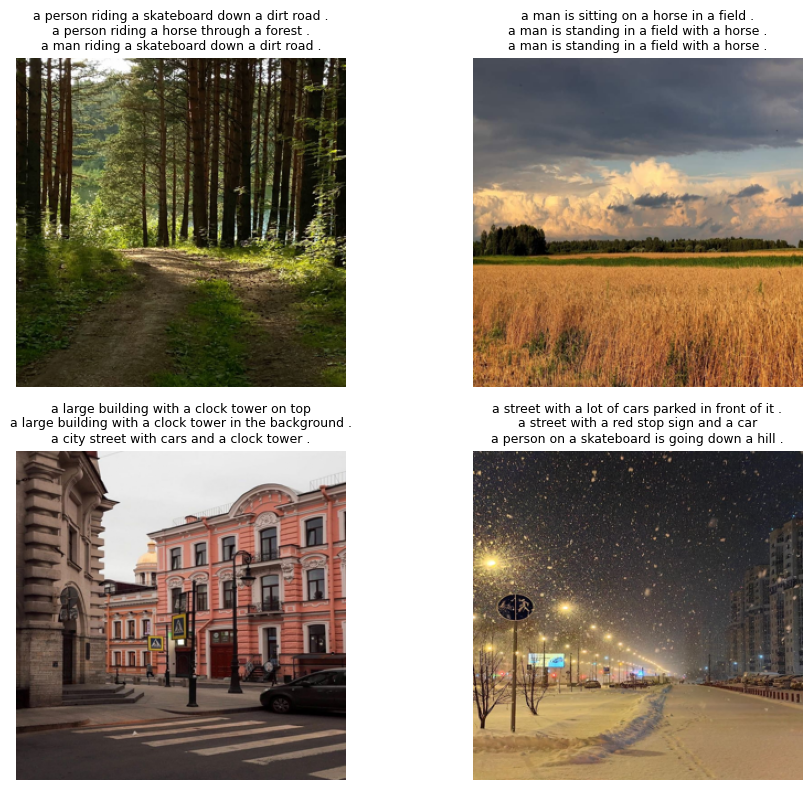

In [347]:
show_next_batch()

5) Картинки, отклоняющиеся от стандартных хотя бы немного угадывает плохо

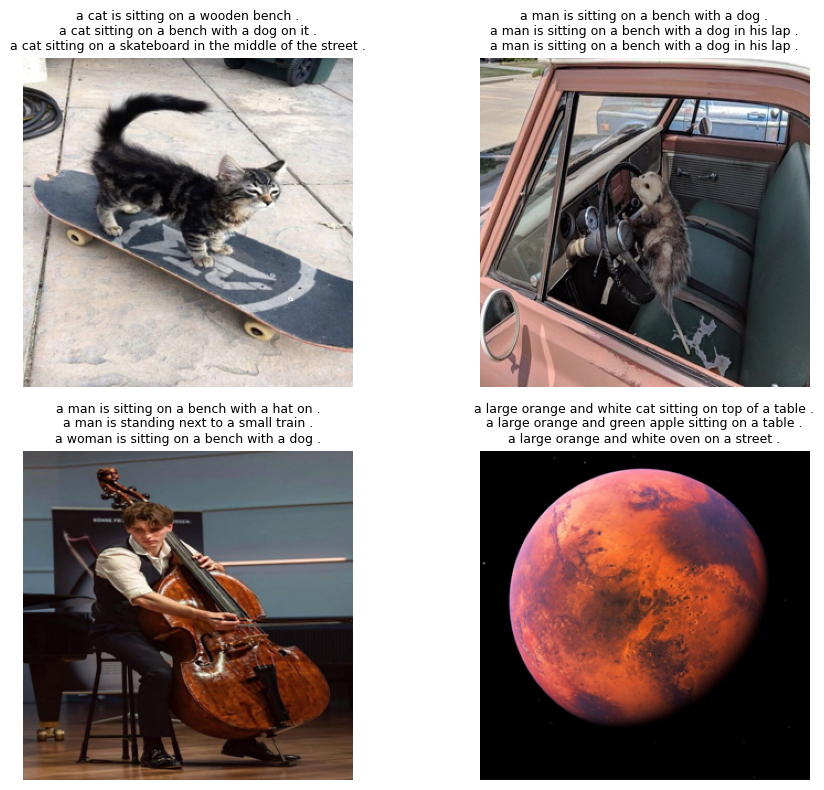

In [348]:
show_next_batch()

## 5. Вывод
Моделька полагается на самые вероятные сценарии, поэтому для своей предметной области надо дообучать. Наверно еще можно поднять температуру.